--- Φόρτωση και Προετοιμασία Δεδομένων ---
Dataset Overview:
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

 

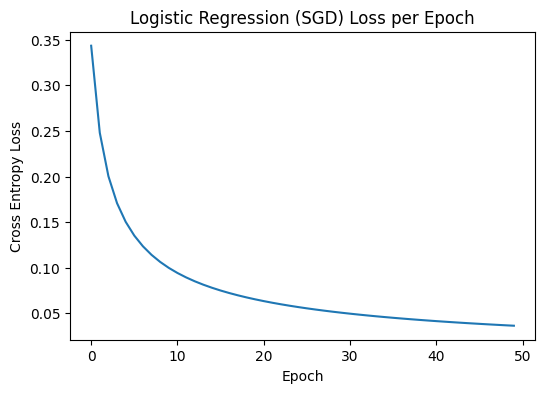

Train Accuracy (Logistic Regression): 1.0000
Test Accuracy (Logistic Regression):  0.9815

--- 4. K-Nearest Neighbors ---
Evaluating k values:
k=1: Accuracy=0.9630
k=2: Accuracy=0.9444
k=3: Accuracy=0.9630
k=4: Accuracy=0.9630
k=5: Accuracy=0.9630
k=6: Accuracy=0.9630
k=7: Accuracy=0.9630
k=8: Accuracy=0.9815
k=9: Accuracy=0.9630
k=10: Accuracy=0.9630
Best k found: 8 with Accuracy: 0.9815

--- 5. Naïve Bayes ---
Train Accuracy (Naïve Bayes): 0.9758
Test Accuracy (Naïve Bayes):  1.0000

--- 6. Multilayer Perceptron ---


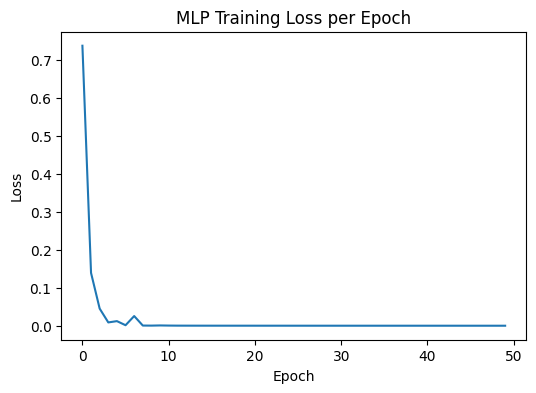

Test Accuracy (MLP): 0.9815

--- 7. Support Vector Machines (SVM) ---
Test Accuracy (Manual SVM One-vs-Rest): 0.9815

--- 8. K-Means ---
K-Means Accuracy (Training Set Purity): 0.9435
Least Squares:       0.9815
Logistic Regression: 0.9815
KNN (Best k=8):   0.9815
Naïve Bayes:         1.0000
MLP :       0.9815
SVM :   0.9815
K-Means:    0.9435


In [ ]:


# Εργασία στο Μάθημα Μηχανικής Μάθησης
# ΑΝΤΩΝΙΟΥ ΔΗΜΗΤΡΙΟΣ AM:3230011
# Προγραμματιστικο Περιβαλλον: Google Colab


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset


np.random.seed(42)
torch.manual_seed(42)


print("Δεδομένα")
data = load_wine()
dataset = pd.DataFrame(data.data, columns=data.feature_names)
dataset['target'] = data.target

print("Dataset Overview:")
print(dataset.head())
print(dataset.info())

X = dataset.drop(columns=['target']).values
y = dataset['target'].values


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("-" * 50)



# 1. Principal Component Analysis

print("\n--- 1. Principal Component Analysis  ---")

def pca(X, m):

    mean = np.mean(X, axis=0)
    X_centered = X - mean


    covariance_matrix = np.cov(X_centered, rowvar=False)


    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)


    sorted_indices = np.argsort(eigenvalues)[::-1]
    top_eigenvectors = eigenvectors[:, sorted_indices[:m]]


    X_reduced = np.dot(X_centered, top_eigenvectors)
    return X_reduced

# test PCA
m_dims = 5
X_train_pca = pca(X_train, m_dims)
print(f"PCA Completed. Original Shape: {X_train.shape}, Reduced Shape: {X_train_pca.shape}")



# 2. Least Squares

print("\n--- 2. Least Squares ---")

def least_squares(X, y):

    X_bias = np.hstack([np.ones((X.shape[0], 1)), X])



    weights = np.linalg.pinv(X_bias.T @ X_bias) @ X_bias.T @ y
    return weights

def predict_least_squares(X, weights):
    X_bias = np.hstack([np.ones((X.shape[0], 1)), X])
    predictions = X_bias @ weights

    return np.argmax(predictions, axis=1)


num_classes = len(np.unique(y_train))
y_train_one_hot = np.eye(num_classes)[y_train]


weights_ls = least_squares(X_train, y_train_one_hot)


train_pred_ls = predict_least_squares(X_train, weights_ls)
test_pred_ls = predict_least_squares(X_test, weights_ls)

print(f"Train Accuracy (Least Squares): {np.mean(train_pred_ls == y_train):.4f}")
print(f"Test Accuracy (Least Squares):  {np.mean(test_pred_ls == y_test):.4f}")



# 3. Logistic Regression

print("\n--- 3. Logistic Regression ---")

def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -250, 250)))

def logistic_regression_sgd(X, y, learning_rate=0.01, epochs=50):
    X_bias = np.hstack([np.ones((X.shape[0], 1)), X])
    n_samples, n_features = X_bias.shape
    n_classes = y.shape[1]

    weights = np.zeros((n_features, n_classes))
    losses = []

    for epoch in range(epochs):

        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        X_shuffled = X_bias[indices]
        y_shuffled = y[indices]


        for i in range(n_samples):
            xi = X_shuffled[i:i+1]
            yi = y_shuffled[i:i+1]

            z = np.dot(xi, weights)
            prob = sigmoid(z)
            error = prob - yi


            gradient = np.dot(xi.T, error)
            weights -= learning_rate * gradient


        full_z = np.dot(X_bias, weights)
        full_prob = sigmoid(full_z)
        loss = -np.mean(y * np.log(full_prob + 1e-9) + (1 - y) * np.log(1 - full_prob + 1e-9))
        losses.append(loss)


    plt.figure(figsize=(6, 4))
    plt.plot(losses)
    plt.title("Logistic Regression (SGD) Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Cross Entropy Loss")
    plt.show()

    return weights

def predict_lr(X, weights):
    X_bias = np.hstack([np.ones((X.shape[0], 1)), X])
    probs = sigmoid(np.dot(X_bias, weights))
    return np.argmax(probs, axis=1)


weights_lr = logistic_regression_sgd(X_train, y_train_one_hot, learning_rate=0.01, epochs=50)


train_acc_lr = np.mean(predict_lr(X_train, weights_lr) == y_train)
test_acc_lr = np.mean(predict_lr(X_test, weights_lr) == y_test)

print(f"Train Accuracy (Logistic Regression): {train_acc_lr:.4f}")
print(f"Test Accuracy (Logistic Regression):  {test_acc_lr:.4f}")



# 4. K-Nearest Neighbors

print("\n--- 4. K-Nearest Neighbors ---")

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2, axis=1))

def knn_predict(X_train, y_train, X_test, k):
    predictions = []
    for test_point in X_test:
        distances = euclidean_distance(X_train, test_point)
        k_indices = np.argsort(distances)[:k]
        k_nearest_labels = y_train[k_indices]
        predictions.append(np.bincount(k_nearest_labels).argmax())
    return np.array(predictions)


k_values = range(1, 11)
best_k = 1
best_acc = 0

print("Evaluating k values:")
for k in k_values:
    preds = knn_predict(X_train, y_train, X_test, k)
    acc = np.mean(preds == y_test)
    print(f"k={k}: Accuracy={acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        best_k = k

print(f"Best k found: {best_k} with Accuracy: {best_acc:.4f}")



# 5. Naïve Bayes
#
print("\n--- 5. Naïve Bayes ---")

def fit_naive_bayes(X, y):
    n_samples, n_features = X.shape
    classes = np.unique(y)
    n_classes = len(classes)

    means = np.zeros((n_classes, n_features))
    vars_ = np.zeros((n_classes, n_features))
    priors = np.zeros(n_classes)


    for idx, c in enumerate(classes):
        X_c = X[y == c]
        means[idx, :] = X_c.mean(axis=0)
        vars_[idx, :] = X_c.var(axis=0) + 1e-9
        priors[idx] = X_c.shape[0] / float(n_samples)

    return means, vars_, priors, classes

def predict_naive_bayes(X, means, vars_, priors, classes):
    y_pred = []
    for x in X:
        posteriors = []
        for idx, c in enumerate(classes):
            prior = np.log(priors[idx])
            numerator = np.exp(-((x - means[idx])**2) / (2 * vars_[idx]))
            denominator = np.sqrt(2 * np.pi * vars_[idx])
            log_likelihood = np.sum(np.log(numerator / denominator))
            posteriors.append(prior + log_likelihood)
        y_pred.append(classes[np.argmax(posteriors)])
    return np.array(y_pred)


means, vars_, priors, classes = fit_naive_bayes(X_train, y_train)
train_pred_nb = predict_naive_bayes(X_train, means, vars_, priors, classes)
test_pred_nb = predict_naive_bayes(X_test, means, vars_, priors, classes)

print(f"Train Accuracy (Naïve Bayes): {np.mean(train_pred_nb == y_train):.4f}")
print(f"Test Accuracy (Naïve Bayes):  {np.mean(test_pred_nb == y_test):.4f}")


# 6. Multilayer Perceptron
print("\n--- 6. Multilayer Perceptron ---")


X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)


class MLP(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_inputs, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, n_outputs)
        )
    def forward(self, x):
        return self.model(x)

model = MLP(X_train.shape[1], 3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 50
mlp_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    mlp_losses.append(avg_loss)

plt.figure(figsize=(6, 4))
plt.plot(mlp_losses)
plt.title("MLP Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

model.eval()
with torch.no_grad():
    outputs = model(X_test_t)
    _, predicted = torch.max(outputs, 1)
    acc = (predicted == y_test_t).float().mean().item()

print(f"Test Accuracy (MLP): {acc:.4f}")



# 7. Support Vector Machines

print("\n--- 7. Support Vector Machines (SVM) ---")

class LinearSVM_Manual:
    def __init__(self, lr=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = lr
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y[idx]))
                    self.b -= self.lr * y[idx]

    def predict_score(self, X):
        return np.dot(X, self.w) - self.b

svm_models = []
unique_classes = np.unique(y_train)

for c in unique_classes:
    y_binary = np.where(y_train == c, 1, -1)

    svm = LinearSVM_Manual(lr=0.001, n_iters=1000)
    svm.fit(X_train, y_binary)
    svm_models.append(svm)

scores = np.zeros((X_test.shape[0], len(unique_classes)))
for idx, svm in enumerate(svm_models):
    scores[:, idx] = svm.predict_score(X_test)

svm_preds = np.argmax(scores, axis=1)
print(f"Test Accuracy (Manual SVM One-vs-Rest): {np.mean(svm_preds == y_test):.4f}")


# 8. K-Means
print("\n--- 8. K-Means ---")

def kmeans_manual(X, k, max_iters=100):

    indices = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[indices]

    for _ in range(max_iters):

        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        cluster_labels = np.argmin(distances, axis=1)


        new_centroids = np.array([X[cluster_labels == i].mean(axis=0)
                                  if np.sum(cluster_labels==i) > 0 else centroids[i]
                                  for i in range(k)])

        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    return cluster_labels

k_clusters = 3
train_clusters = kmeans_manual(X_train, k_clusters)

cluster_map = {}
for i in range(k_clusters):
    indices = np.where(train_clusters == i)
    if len(indices[0]) > 0:
        true_labels = y_train[indices]
        mode = np.bincount(true_labels).argmax()
        cluster_map[i] = mode
    else:
        cluster_map[i] = np.random.choice(unique_classes)

mapped_preds = np.array([cluster_map[c] for c in train_clusters])
print(f"K-Means Accuracy (Training Set Purity): {np.mean(mapped_preds == y_train):.4f}")


ls_accuracy = np.mean(test_pred_ls == y_test)
nb_accuracy = np.mean(test_pred_nb == y_test)
svm_accuracy = np.mean(svm_preds == y_test)
kmeans_accuracy = np.mean(mapped_preds == y_train)

# Εκτύπωση
print(f"Least Squares:       {ls_accuracy:.4f}")
print(f"Logistic Regression: {test_acc_lr:.4f}")
print(f"KNN (Best k={best_k}):   {best_acc:.4f}")
print(f"Naïve Bayes:         {nb_accuracy:.4f}")
print(f"MLP :       {acc:.4f}")
print(f"SVM :   {svm_accuracy:.4f}")
print(f"K-Means:    {kmeans_accuracy:.4f}")